# 01-BloodDeconvolution_Music_withSeqwell

In [7]:
# Load libraries
suppressPackageStartupMessages(library(MuSiC))
suppressPackageStartupMessages(library(xbioc))
suppressPackageStartupMessages(library(Biobase))
suppressPackageStartupMessages(library(SummarizedExperiment))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(Biobase))

## Load prepared single-cell reference (seq-well)

In [2]:
sc_reference <- readRDS('/home/nbarkas/disk3/ebov_bulk_rna_seq/proc_20210524/18-CompositionDeconvolution/00-reference_data/01-EBOV_sc/01-prepare-eset/eset_sc.rds')

In [3]:
genenames_in_single_cell <- rownames(exprs(sc_reference))

In [4]:
head(genenames_in_single_cell)

[1] "ADSS"   "PTGER2" "EGLN3"  "CMC1"   "TOPBP1" "BGLAP"

In [5]:
# Do we have any non-SYMBOL identifiers? Such as Ensembl ids
genenames_in_single_cell[grepl('^EN',x=genenames_in_single_cell)]

[1] "ENPEP"  "ENO2"   "ENKD1"  "ENTPD3" "ENC1"

## Load bulk data and convert to Eset

In [6]:
bulk_qc_summarized_experiment_path <- "/home/nbarkas/disk3/ebov_bulk_rna_seq/proc_20210524/03-sample_qc/se.qc.rds"

In [7]:
bulk.se.qc <- readRDS(bulk_qc_summarized_experiment_path)

In [8]:
# What are the identifiers for the bulk dataset?
head(rownames(assay(bulk.se.qc)))

[1] "ENSMMUG00000023296.4" "ENSMMUG00000036181.3" "ENSMMUG00000000634.4"
[4] "ENSMMUG00000037875.2" "ENSMMUG00000000632.4" "ENSMMUG00000064799.1"

## Convert single-cell to ensembl ids with version

In [23]:
sc_reference_assaydata <- assayData(sc_reference)

In [24]:
sc_refernce_phenodata <- phenoData(sc_reference)

In [26]:
sc_reference_experimentdata <- experimentData(sc_reference)

In [43]:
sc_reference_exprs <- sc_reference_assaydata$exprs

In [44]:
# Convert
gene_conversion_table <- read.csv('gene_conversion.csv')
mo <-  match(rownames((sc_reference_exprs)), gene_conversion_table$external_gene_name) 
table(is.na(mo))


FALSE  TRUE 
 2069    24 

In [45]:
v <- make.unique(make.names(gene_conversion_table[mo,"ensembl_gene_id_version"]))

In [46]:
sc_refernce_phenodata

An object of class 'AnnotatedDataFrame'
  sampleNames:
    RA0223.D000.fresh.a1.DASH1.std_88_NovaNext_Merged_AAAACAAGACTT
    RA0223.D000.fresh.a1.DASH1.std_88_NovaNext_Merged_AAAACACGCTTC ...
    RA1834.D003.fresh.a1.DASH.DASH2_88_NovaNext_Merged_TTTTAGCCTGCC
    (65232 total)
  varLabels: Cell_Barcode Cell_Type
  varMetadata: labelDescription

In [47]:
rownames(sc_reference_exprs) <- v

In [48]:
head(rownames(sc_reference_exprs))

[1] "NA."                  "ENSMMUG00000000023.4" "ENSMMUG00000000040.4"
[4] "ENSMMUG00000000055.4" "ENSMMUG00000000059.4" "ENSMMUG00000004902.4"

In [49]:
dim(sc_reference_exprs)

[1]  2093 65232

In [50]:
sc_reference_2 <- ExpressionSet(
    assayData=sc_reference_exprs,
    phenoData=sc_refernce_phenodata)

# Subset bulk to samples of interest


In [51]:
tissue_of_interest <- "Whole blood"
se.qc.tissue <- bulk.se.qc[,bulk.se.qc$full.tissue == tissue_of_interest & bulk.se.qc$SampleType == 'Experimental']

In [52]:
# remove viral genes
se.qc.tissue <- se.qc.tissue[!rowData(se.qc.tissue)$viralGene,]

In [53]:
# Get the data we need
cm <- assay(se.qc.tissue)
pheno <- colData(se.qc.tissue)

In [54]:
cm[1:3,1:3]

,A0295_S16_L001,A0297_S14_L001,A0298_S192_L002
ENSMMUG00000023296.4,7,9,7
ENSMMUG00000036181.3,1,0,1
ENSMMUG00000000634.4,264,138,126


In [55]:
pheno[1:3,1:6]

DataFrame with 3 rows and 6 columns
                file_identifiers A.identifier              biosample
                     <character>  <character>            <character>
A0295_S16_L001    A0295_S16_L001        A0295 RA1082_WholeBlood-Dm..
A0297_S14_L001    A0297_S14_L001        A0297   RA1082_WholeBlood-D0
A0298_S192_L002  A0298_S192_L002        A0298   RA1819_WholeBlood-BL
                batch.extraction irf.study.id id.cohort
                     <character>  <character>  <factor>
A0295_S16_L001          B, ABCDE        49-E2      D-30
A0297_S14_L001          B, ABCDE        49-E2      D000
A0298_S192_L002                F        49-E2      D-28

In [56]:
# convert bulk data to eset
eset_bulk <- ExpressionSet(cm,phenoData = AnnotatedDataFrame(as.data.frame(pheno)))

In [57]:
## Check feature commonality

In [58]:
ens_ids <- rownames(eset_bulk)

In [59]:
head(ens_ids)

[1] "ENSMMUG00000023296.4" "ENSMMUG00000036181.3" "ENSMMUG00000000634.4"
[4] "ENSMMUG00000037875.2" "ENSMMUG00000000632.4" "ENSMMUG00000064799.1"

In [60]:
head(rownames(eset_bulk))

[1] "ENSMMUG00000023296.4" "ENSMMUG00000036181.3" "ENSMMUG00000000634.4"
[4] "ENSMMUG00000037875.2" "ENSMMUG00000000632.4" "ENSMMUG00000064799.1"

In [65]:
head(rownames(sc_reference))

[1] "ADSS"   "PTGER2" "EGLN3"  "CMC1"   "TOPBP1" "BGLAP"

### Run deconvolution

In [ ]:
start_time <- proc.time()
est_prop = music_prop(bulk.eset = eset_bulk,
                      sc.eset = sc_reference_2, 
                      clusters = 'Cell_Type',
                      samples = 'Cell_Barcode', 
                      verbose = T)
end_time <- proc.time()

Creating Relative Abudance Matrix...



In [66]:
end_time - start_time

     user    system   elapsed 
10549.319   112.749 10572.246 

In [69]:
fastSave::preserve.state()

[1] "savepoint_2021-07-06_12:50:53_16805.RDataFS"

In [1]:
fastSave::load.lbzip2('savepoint_2021-07-06_12:50:53_16805.RDataFS')

In [4]:
suppressPackageStartupMessages(library(tidyverse))

In [2]:
plot_ebov_deconvolution <- function(music_results, se.obj, return_data = FALSE) {
    # prepare results into long format
    res1 <- as.data.frame(music_results$Est.prop.weighted)
    res1$file_identifiers <- rownames(res1)
    rownames(res1) <- NULL
    res1 %>% pivot_longer(cols=!file_identifiers,names_to="celltype") -> res1_long
    
    # prepare metadata
    meta <- colData(se.obj)
    meta <- meta[,c('file_identifiers','id.individual','dpi_time_factor')]
    res1_merged <- merge(meta, res1_long)
    res1_merged <- as.data.frame(res1_merged)
    
    if (return_data) {
        res1_merged
    } else {
        # generate plot
        p <- ggplot(res1_merged, aes(x=dpi_time_factor,y=value)) + geom_point() + facet_wrap(~celltype)
        p
    }

}

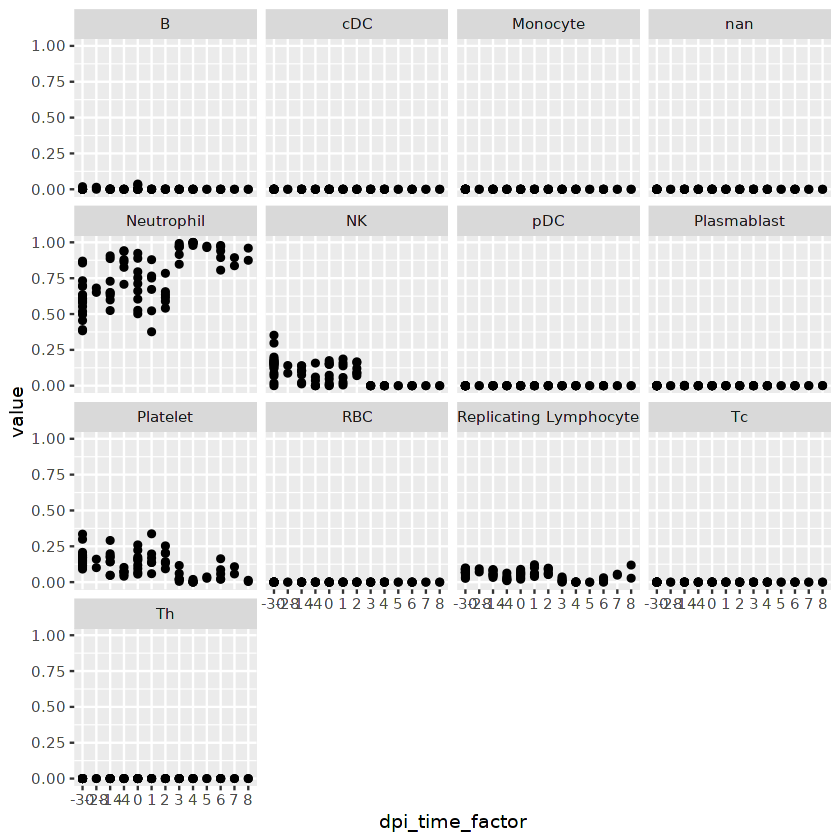

In [8]:
plot_ebov_deconvolution(est_prop, bulk.se.qc)

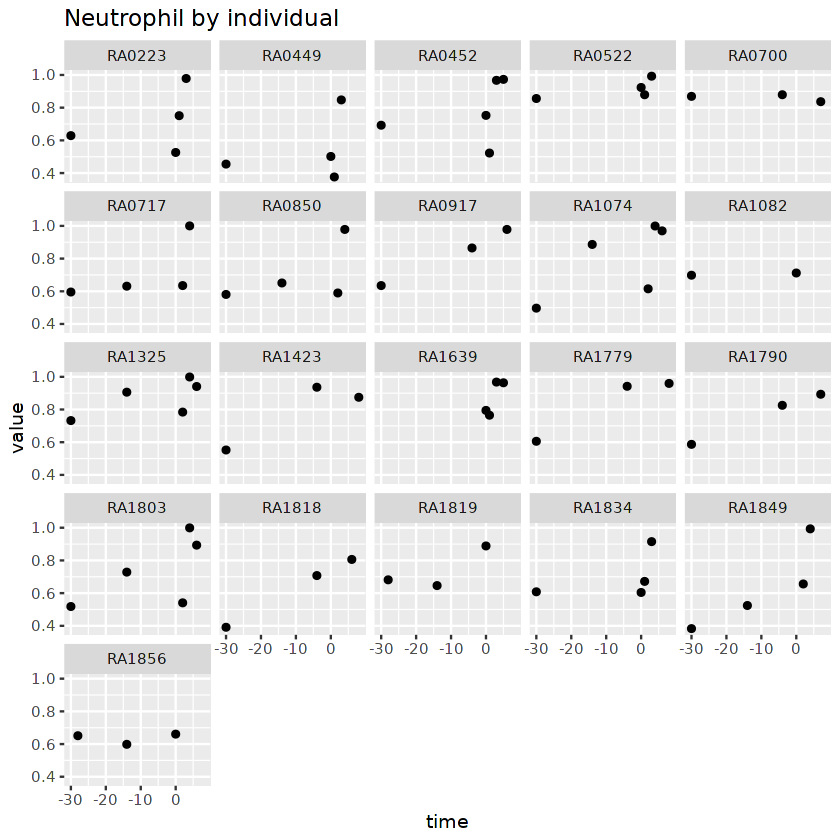

In [14]:
plot_ebov_deconvolution(est_prop, bulk.se.qc, return_data=TRUE) %>% 
    mutate(time = as.numeric(as.character(dpi_time_factor))) %>%
    subset(celltype=="Neutrophil") %>%
    ggplot(aes(x=time,y=value)) + geom_point() + facet_wrap(~id.individual) +
    ggtitle('Neutrophil by individual')